In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2

galaxy_name = 'DDO167'
box_size = 200
window_size = (40, 40)


# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"c:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 167\d167u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"c:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 167\d167b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"c:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 167\d167v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b), np.shape(light_v))

(1011, 1011) (1011, 1011) (1011, 1011)


(1011, 1011) (1011, 1011) (1011, 1011)


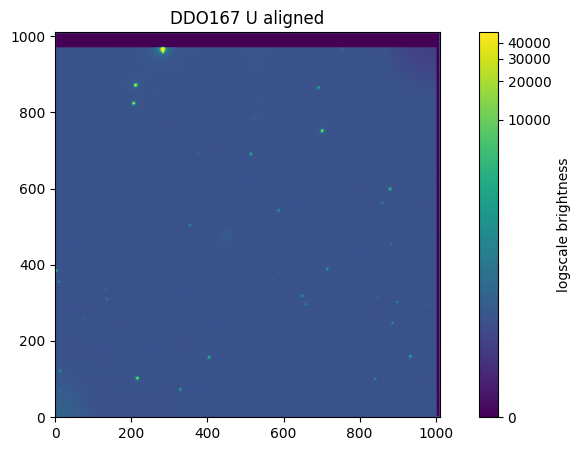

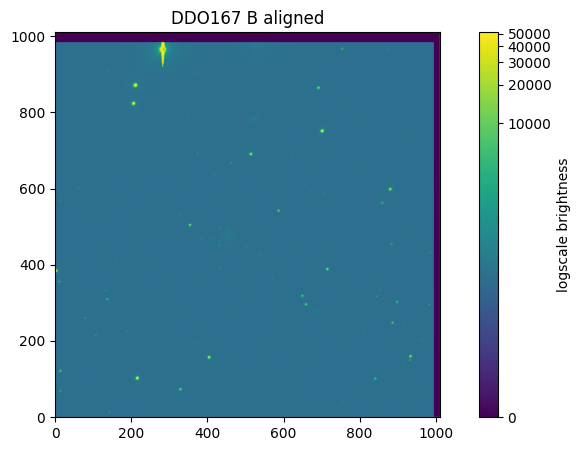

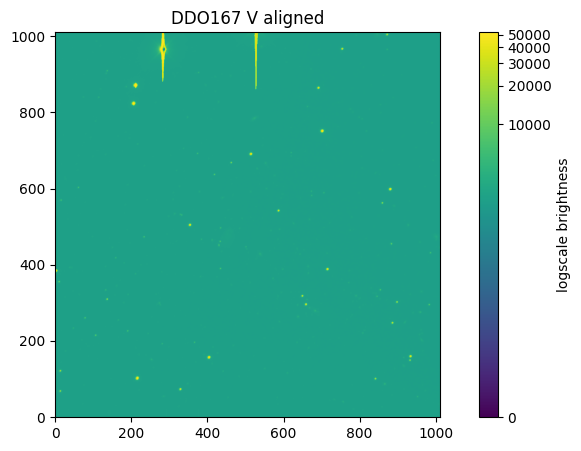

In [2]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_1 = lights[0].byteswap().newbyteorder('N')
source_fixed_2 = lights[1].byteswap().newbyteorder('N')

registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [registered_image_1, registered_image_2, lights[2] ]

print(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2]), np.shape(list_of_aligned_images[2]))
aligned = list_of_aligned_images

for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

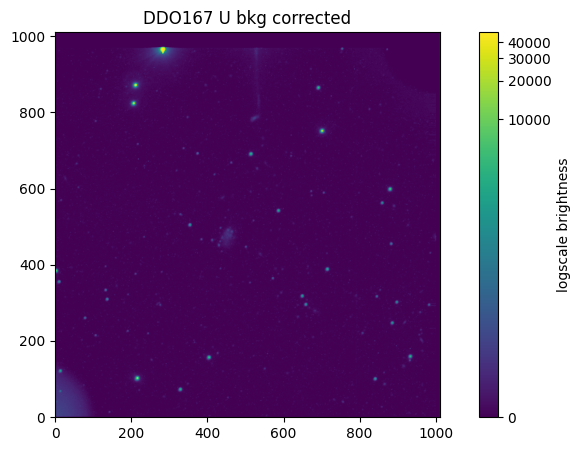

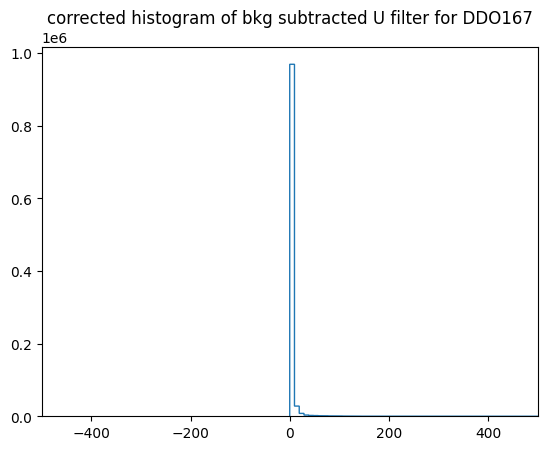

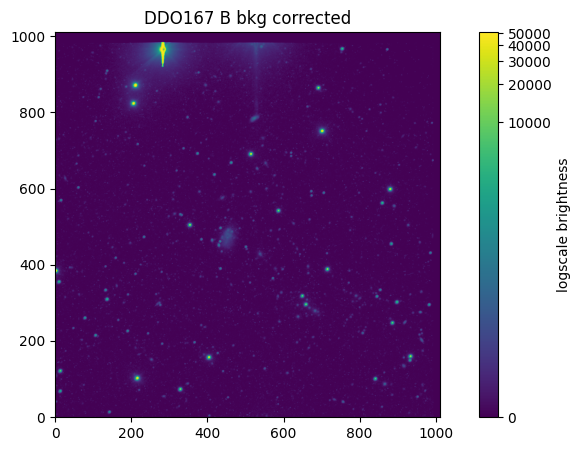

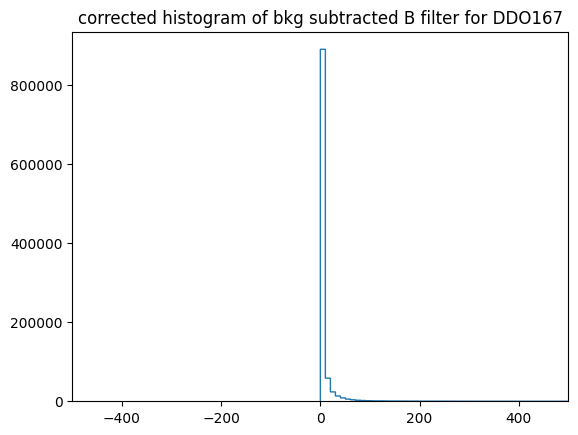

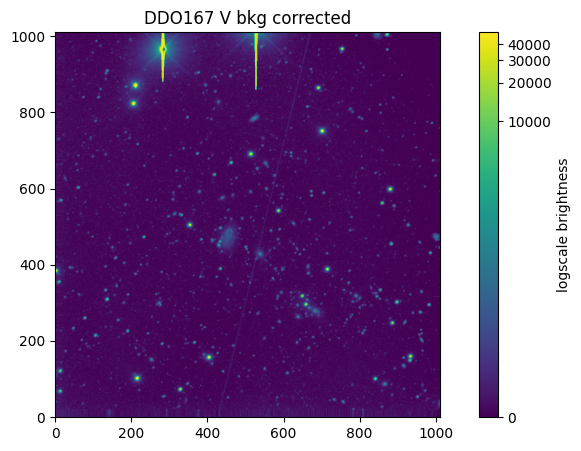

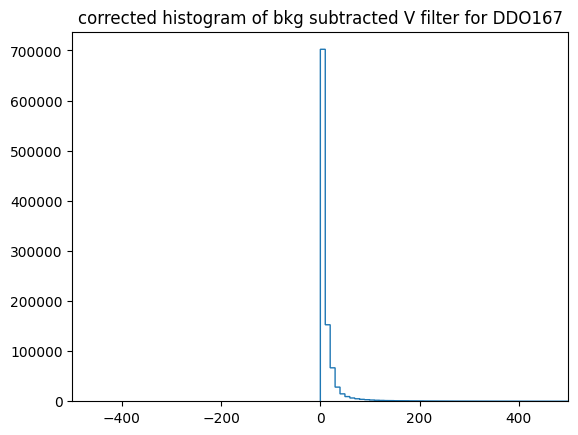

In [3]:
def background_subtraction(light_images,sigma,boxes_list,filter_size):
    background_corrected_lights = []
    for j in range(0 , len(light_images)): 
    # create background------------------------------------------------------------------------------------------------------------------------------------------------
        sigma_clip = SigmaClip(sigma=sigma)
        bkg_estimator = SExtractorBackground()
        bkg = Background2D(light_images[j], boxes_list[j] , filter_size=filter_size,
        sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        light_minus_bkg = light_images[j] - bkg.background
        corrected_light = light_minus_bkg 
        corrected_light[corrected_light <= 0] = 1
        
        background_corrected_lights.append(corrected_light)
    return background_corrected_lights
corrected = background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

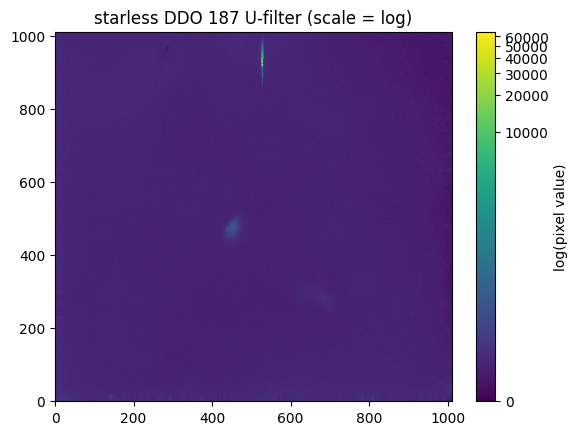

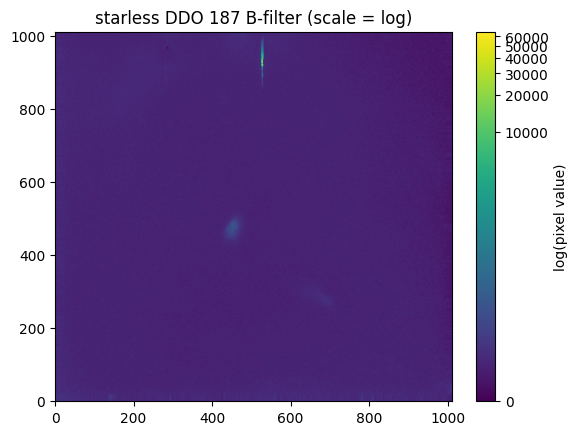

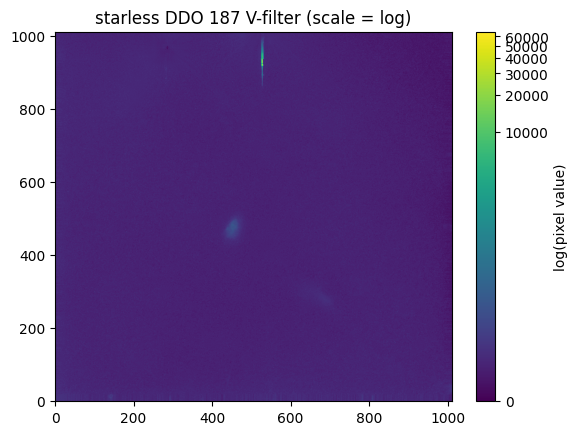

In [5]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------

starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d167\starless\starless_backgroundless_d167.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d167\starless\starless_backgroundless_d167.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d167\starless\starless_backgroundless_d167.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]
norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto' ,norm = norm)
    plt.title('starless DDO 187 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

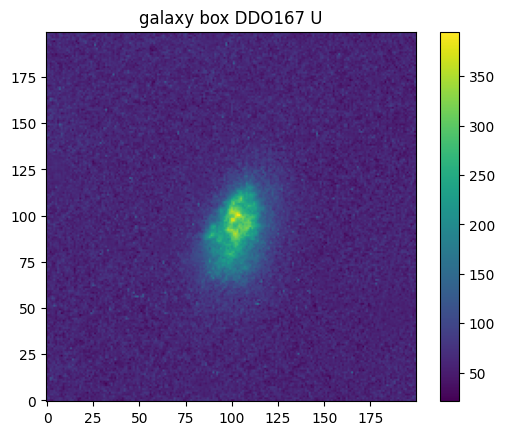

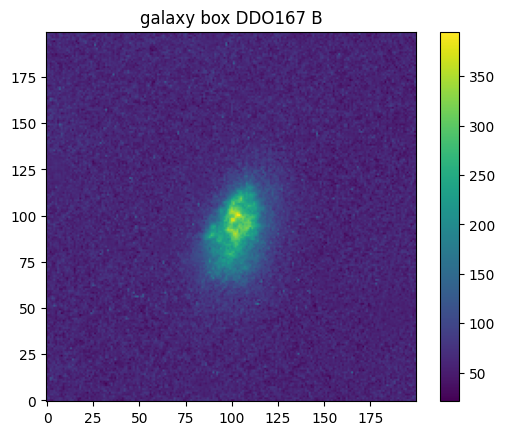

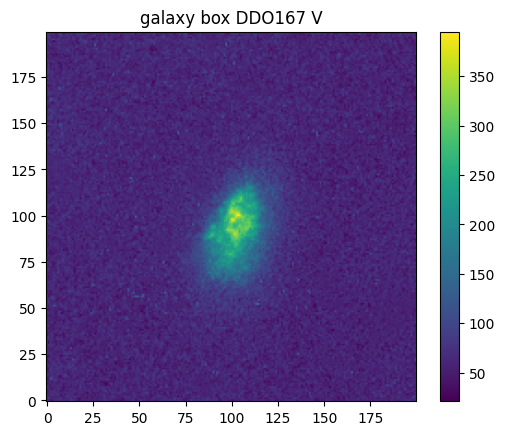

In [7]:
box_size_x = 100
box_size_y = 100
box_center = [450,480]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        galaxy_boxes.append(box)
for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

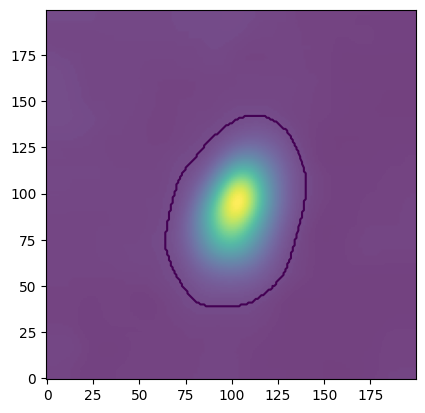

In [8]:
v_value_box = galaxy_boxes[2]
smoothed = gaussian_filter(v_value_box, 5)
contour_points = ltf.contour_lines_coordinates(smoothed, 5, [64])
x_points , y_points = contour_points

(99.10656093014299, 98.90346180621013)
35.43770019393245
[102.86874682  88.86924057  35.43770019  53.30775394  -0.3009241 ]


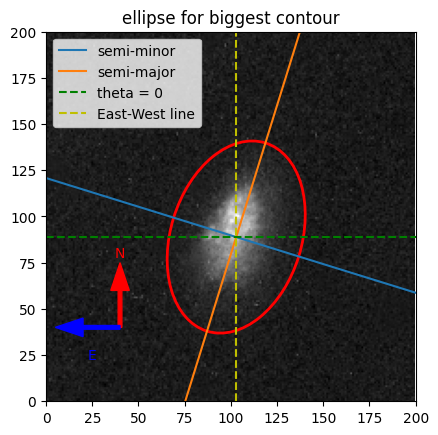

what we measure  -17.241680642869525
paper = -23


In [10]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(a)
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax, label = "semi-minor")

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax, label="semi-major")

plt.axhline(y=yc, color='g', linestyle='--', label = "theta = 0")
plt.axvline(x=xc,  color='y', linestyle='--', label="East-West line")

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO168 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=40, y=40, dx=0, dy=20, color='red', width=2, head_width=10)
plt.arrow(x=40, y=40, dx=-20, dy=0, color='blue', width=2, head_width=10)
plt.text(40, 80, 'N', color='red', fontsize=10, ha='center', va='center')
plt.text(25, 25, 'E', color='blue', fontsize=10, ha='center', va='center')

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for biggest contour")
plt.legend()
# Show the plot
plt.show()
import math
angle_in_degrees = math.degrees(theta)

print("what we measure " , angle_in_degrees)


print("paper = -23")

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_33024\1695093212.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


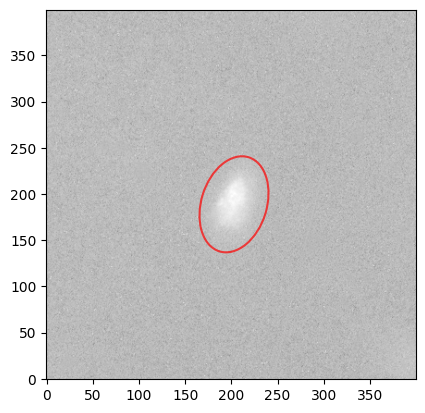

In [11]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
plus = 100
bigger_v_box = starless[2][box_center[1] - (box_size_y+plus) : box_center[1] + (box_size_y+plus), box_center[0] - (box_size_x+plus) : box_center[0] + (box_size_x+plus)]

elliptical_center_box = (xc,yc)
new_xc = xc + int(plus)
new_yc = yc + int(plus)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_33024\2257863402.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_33024\2257863402.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


0.6647757140743409
Aperture sums: [1.0115928344559134e-09, 781.9969049544311, 3073.5491353691555, 6699.709507172806, 11620.554610821939, 17722.87779405939, 24898.037540763045, 33094.35256720333, 42623.56221386334, 53409.92907917109, 65361.36956023552, 78391.74134912773, 92087.32418249495, 106358.77752164564, 121289.99915827159, 136671.81947913935, 152292.99997218468, 168177.41173236343, 184571.06070361915, 201495.08296186855, 218433.80706334338, 235285.30710279313, 251913.87012270684, 268075.1136754492, 283613.69963451294, 298664.46266386844, 313447.20762926305, 327703.27438096574, 341690.8218040478, 355435.931148508, 369197.1527770364, 382985.1966286935, 396738.1625677828, 410643.8440666018, 424249.15407733247, 437920.083495499, 451660.14550309523, 465321.53664564464, 479086.441956213, 492854.58375102835, 506751.05952788086, 521160.49264992424, 535758.1463370804, 550506.7335462305, 565181.0933484384, 579688.5690494396, 594420.6090344258, 609303.9008283259, 624519.5438160478, 639487.24

Text(0.5, 1.0, ' curve of growth for DDO154')

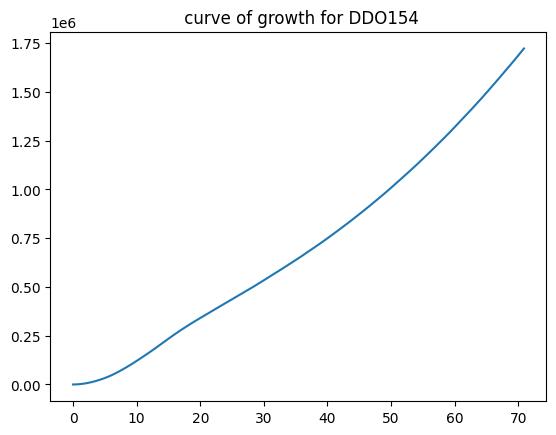

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
print(ab_ratio)
a_list = np.linspace(0, 2*a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(bigger_v_box, cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO154")

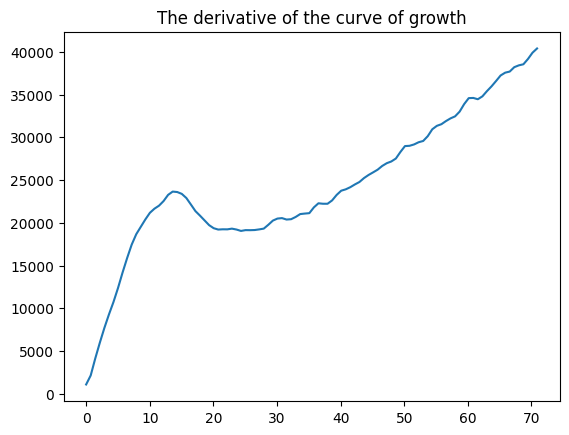

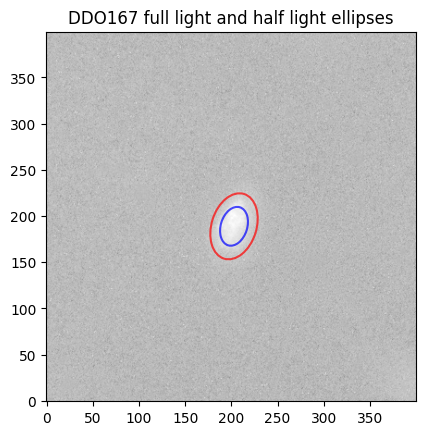

galaxy parameter a =  24.341046597852593 and galaxy parameter b =  36.615426951548606
galaxy count 424249.15407733247
galaxy half light a =  14.31826270461917 and galaxy half light b =  21.538486442087414
half light count 218433.80706334338
-0.30092409579544577


In [13]:
gradient_sum = np.gradient(sum_values, a_list)
plt.title("The derivative of the curve of growth")
plt.plot(a_list, gradient_sum)
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)
peak_index = peaks[0]
min_after_peak = np.min(gradient_sum[peak_index + 1:])
min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio
whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))

a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_b)
print("galaxy count", sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print("half light count", sum_values[half_light_index])
ratio = sum_values[half_light_index]/whole_galaxy
print(theta)

In [15]:
pixel_scale = 1.134

D = 4.2

a_half_light_arcsec = b_half_light * pixel_scale
RV_half = (D * a_half_light_arcsec)/206265

print("RV1/2 for DDO69 is: ", RV_half*(10**3), "kpc")
print("paper value is 0.52 kpc")

RV1/2 for DDO69 is:  0.49733839103276817 kpc
paper value is 0.52 kpc


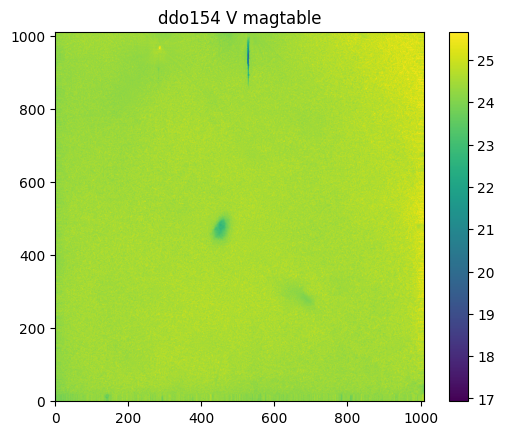

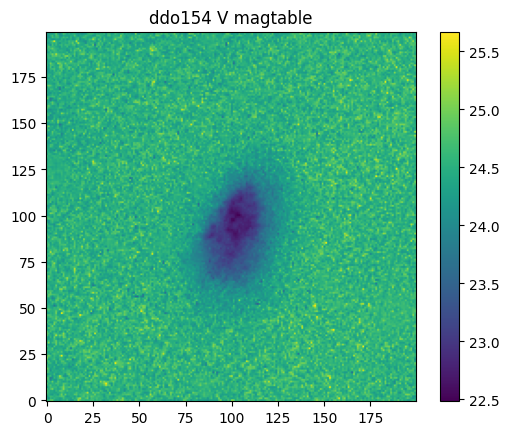

In [17]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
exposures = [1800, 1200, 600]
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

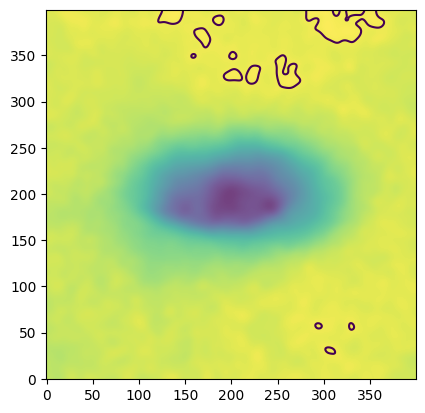

In [ ]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [ ]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(199.62617153519398, 199.64821113888277)


In [ ]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.